# Mohammad GharehHasanloo
## AI Medic Internship
## Second Project

### Import Necessary Libraries

In [3]:
import cv2
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import Model, layers, Sequential
import tensorflow.keras.layers as tfkl
from random import shuffle
%matplotlib inline 
from matplotlib import pyplot as plt

PNG_FOLDER_NAME = 'samples'
DEFAULT_CAPTCHA_LENGTH = 5

### Load Images from Folder and Convert Images to Grayscale Form
load data and apply necessary preprocessing operations to the data

In [2]:
def delete_noisy_line(image:list):
    """ Some processes to delete line on the letters

    Args:
        image (list): input image that has been loaded recently

    Returns:
        image (list): converted image to approximately delete noisy line
    """
    image = cv2.blur(image, (3, 3))
    ret, image = cv2.threshold(image, 90, 255, cv2.THRESH_BINARY)

    image = cv2.dilate(image, np.ones((3, 1), np.uint8))
    image = cv2.erode(image, np.ones((2, 2), np.uint8))

    return image


def load_images_from_folder(folder:str, shuffled_files:list):
    """ This function load images from the determined folder

    Args:
        folder (str): the name of folder
        shuffled_files (list): list of files in determined folder those are shuffled

    Returns:
        images (list): the variable to save images
        splited_labels (list): return the characters of what images show
        unique_chars (dict): the unique characters that have been found in labels
    """
    images = []
    labels = []
    unique_chars = {}
    
    for filename in shuffled_files:
        img = cv2.imread(os.path.join(folder,filename), cv2.IMREAD_GRAYSCALE)
        img = delete_noisy_line(img)
        
        # Add image with its label to `images` and `labels`
        if img is not None:
            images.append(img)
            labels.append(filename.split('.')[0])
            
            # Find unique characters with their number
            for char in filename.split('.')[0]:
                if char in unique_chars:
                    unique_chars[char] += 1
                else:
                    unique_chars[char] = 1
                    
    return images, labels, unique_chars



def preprocess_data(images:np.ndarray, labels:np.ndarray, unique_chars:dict, shuffled_files:list):
    """ This function apply preprocess images and labels to convert them to proper shape 

    Args:
        images (np.ndarray): The images those are saved in the type of array
        labels (np.ndarray):  the labels in shape: (sample's count,)
        unique_chars (dict): unique chars that are found in captchas
        shuffled_files (list): list of files in determined folder those are shuffled

    Returns:
        X (np.ndarray): converted images in shape: (sample's count, height, width, 1)
        y (np.ndarray): converted labels in shape: (length of each example, sample's count, unique chars)
    """
    captcha_length = len(labels[0])
    unique_chars_count = len(unique_chars)    
       
    X = np.zeros(images[...,  np.newaxis].shape)
    y = np.zeros((captcha_length, len(labels), unique_chars_count))
    
    for i, img in enumerate(shuffled_files):
        # Divide cells of images by 255 to learn more quickly in neural network
        captcha_img = images[i]
        captcha_img = captcha_img/255.0
        
        # Reshape `images`
        captcha_img = np.reshape(captcha_img, images[0, ...,  np.newaxis].shape)
        X[i] = captcha_img
        
        # Reshape `labels`
        curr_name = np.zeros((captcha_length, unique_chars_count))
        for j, char in enumerate(labels[i]):
            curr_name[j, list(unique_chars.keys()).index(char)] = 1
        y[:, i] = curr_name
        
    return X, y    

In [3]:
# Shuffle folders' name to unorder the files
shuffled_files = os.listdir(PNG_FOLDER_NAME)
shuffle(shuffled_files)

images, labels, unique_chars = load_images_from_folder(PNG_FOLDER_NAME, shuffled_files)
images, labels = np.array(images), np.array(labels)
images, labels = preprocess_data(images, labels, unique_chars, shuffled_files)

unique_chars_count = len(unique_chars)

print(f"images' shape is {images.shape}")
print(f"labels' shape is {labels.shape}")
print(f"unique characters count equals: {unique_chars_count}")

images' shape is (1070, 50, 200, 1)
labels' shape is (5, 1070, 19)
unique characters count equals: 19


#### Plot a Sample

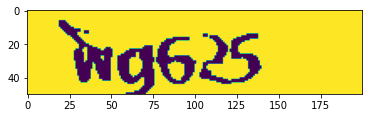

array of label number 32 equals:
 [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]


In [4]:
index = 32
plt.imshow(images[index])
plt.show()
print(f"array of label number {index} equals:\n {labels[:, index]}")

### Design an Object Oriented Network
I design a network that has five `Conv2D` that each one is followed by a `MaxPool2D`.<br/>
Then, it's followed by a `Flatten`, `Dropout` and `BatchNormalization`..<br/>
At last, we have five `Sequential` part those are parallel and each one is used for predicting one letter of the captcha..<br/>
Each Sequential part has one `Dense` with 64 neurons, `Dropout`, `BatchNormalization` and `Dense` the number of output(`num_classes`)

In [5]:
class MyModel(Model):
    def __init__(self, num_classes):
        super(MyModel, self).__init__()
        
        self.layer1 = Sequential([
            tfkl.Conv2D(16, activation='relu', kernel_size=5, strides=1, padding="same"),
            tfkl.MaxPool2D(pool_size=(2, 2), padding='same'),
        ])    
        self.layer2 = Sequential([
            tfkl.Conv2D(32, activation='relu', kernel_size=3, strides=1, padding="same"),
            tfkl.MaxPool2D(pool_size=(2, 2), padding='same'),
        ])    
        self.layer3 = Sequential([
            tfkl.Conv2D(64, activation='relu', kernel_size=3, strides=1, padding="same"),
            tfkl.MaxPool2D(pool_size=(2, 2), padding='same'),
        ])    
        self.layer4 = Sequential([
            tfkl.Conv2D(128, activation='relu', kernel_size=3, strides=1, padding="same"),
            tfkl.MaxPool2D(pool_size=(2, 2), padding='same'),
        ])    
        self.layer5 = Sequential([
            tfkl.Conv2D(256, activation='relu', kernel_size=3, strides=1, padding="same"),
            tfkl.MaxPool2D(pool_size=(2, 2), padding='same'),
        ])
        self.layer6 = Sequential([
            tfkl.Flatten(),
            tfkl.Dropout(0.2),
            tfkl.BatchNormalization(),
        ])
        self.layer7_1 = Sequential([
            tfkl.Dense(64, activation='relu'),
            tfkl.Dropout(0.2),
            tfkl.BatchNormalization(),
            tfkl.Dense(num_classes , activation='softmax', name='char1'),
        ])
        self.layer7_2 = Sequential([
            tfkl.Dense(64, activation='relu'),
            tfkl.Dropout(0.2),
            tfkl.BatchNormalization(),
            tfkl.Dense(num_classes , activation='softmax', name='char2'),
        ])
        self.layer7_3 = Sequential([
            tfkl.Dense(64, activation='relu'),
            tfkl.Dropout(0.2),
            tfkl.BatchNormalization(),
            tfkl.Dense(num_classes , activation='softmax', name='char3'),
        ])
        self.layer7_4 = Sequential([
            tfkl.Dense(64, activation='relu'),
            tfkl.Dropout(0.2),
            tfkl.BatchNormalization(),
            tfkl.Dense(num_classes , activation='softmax', name='char4'),
        ])
        self.layer7_5 = Sequential([
            tfkl.Dense(64, activation='relu'),
            tfkl.Dropout(0.2),
            tfkl.BatchNormalization(),
            tfkl.Dense(num_classes , activation='softmax', name='char5'),
        ])
       
    def call(self, inputs):
        x = self.layer1(inputs)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        output1, output2, output3, output4, output5 = self.layer7_1(x), self.layer7_2(x), self.layer7_3(x), self.layer7_4(x), self.layer7_5(x)
        output = [output1, output2, output3, output4, output5]
        return output        

In [6]:
input = tfkl.Input(images[0].shape)
output = MyModel(unique_chars_count)(input)
 
model = Model(inputs=input, outputs=output)

In [7]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 200, 1)]      0         
                                                                 
 my_model (MyModel)          [(None, 19),              1561567   
                              (None, 19),                        
                              (None, 19),                        
                              (None, 19),                        
                              (None, 19)]                        
                                                                 
Total params: 1,561,567
Trainable params: 1,553,759
Non-trainable params: 7,808
_________________________________________________________________


In [8]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

#### Separate Data to Train and Test
Because we shuffle files based on their names, it doesn't need to shuffle

In [9]:
# Assign 80% data to train
train_size = 0.8
numTrainingSamples = int(len(images) * train_size)
numTestingSamples = int(len(images) - numTrainingSamples)

X_train = images[:numTrainingSamples]
y_train = labels[:, :numTrainingSamples]
X_test = images[numTrainingSamples:]
y_test = labels[:, numTrainingSamples:]

#### Fiting Data

In [10]:
history = model.fit(X_train, [y_train[0], y_train[1], y_train[2], y_train[3], y_train[4]], epochs = 30, batch_size = 32, validation_data=(X_test, [y_test[0], y_test[1], y_test[2], y_test[3], y_test[4]]))

Epoch 1/30
27/27 [==============================] - 12s 291ms/step - loss: 17.7859 - my_model_loss: 3.5475 - my_model_1_loss: 3.5934 - my_model_2_loss: 3.5379 - my_model_3_loss: 3.5183 - my_model_4_loss: 3.5888 - my_model_accuracy: 0.0561 - my_model_1_accuracy: 0.0526 - my_model_2_accuracy: 0.0631 - my_model_3_accuracy: 0.0619 - my_model_4_accuracy: 0.0549 - val_loss: 15.0525 - val_my_model_loss: 2.9813 - val_my_model_1_loss: 3.0202 - val_my_model_2_loss: 2.9747 - val_my_model_3_loss: 2.9846 - val_my_model_4_loss: 3.0916 - val_my_model_accuracy: 0.0654 - val_my_model_1_accuracy: 0.0421 - val_my_model_2_accuracy: 0.0374 - val_my_model_3_accuracy: 0.0280 - val_my_model_4_accuracy: 0.0327
Epoch 2/30
27/27 [==============================] - 6s 234ms/step - loss: 16.2892 - my_model_loss: 3.3070 - my_model_1_loss: 3.2813 - my_model_2_loss: 3.2900 - my_model_3_loss: 3.2389 - my_model_4_loss: 3.1720 - my_model_accuracy: 0.0818 - my_model_1_accuracy: 0.0806 - my_model_2_accuracy: 0.0794 - my_mo

### Evaluation
I evaluate by characters one by one but it doesn't work in character number 1 as good as other characters --> I solve this problem by shuffling<br/>
UPDATE: It works on all characters and return accuracy more than 94% for each character

In [11]:
modelEvaluation = model.evaluate(X_test, [y_test[0], y_test[1], y_test[2], y_test[3], y_test[4]])

7/7 [==============================] - 0s 64ms/step - loss: 0.8947 - my_model_loss: 0.0930 - my_model_1_loss: 0.1632 - my_model_2_loss: 0.2558 - my_model_3_loss: 0.2555 - my_model_4_loss: 0.1271 - my_model_accuracy: 0.9766 - my_model_1_accuracy: 0.9626 - my_model_2_accuracy: 0.9439 - my_model_3_accuracy: 0.9159 - my_model_4_accuracy: 0.9766


In [12]:
print(f'Character1 Prediction Accuracy : {modelEvaluation[6]*100} %')
print(f'Character2 Prediction Accuracy : {modelEvaluation[7]*100} %')
print(f'Character3 Prediction Accuracy : {modelEvaluation[8]*100} %')
print(f'Character4 Prediction Accuracy : {modelEvaluation[9]*100} %')
print(f'Character5 Prediction Accuracy : {modelEvaluation[10]*100} %')

Character1 Prediction Accuracy : 97.66355156898499 %
Character2 Prediction Accuracy : 96.26168012619019 %
Character3 Prediction Accuracy : 94.39252614974976 %
Character4 Prediction Accuracy : 91.58878326416016 %
Character5 Prediction Accuracy : 97.66355156898499 %


#### Plot Diagram to Show Loss in Epochs
the loss in train and test has droped but we can see a little overfitting but that's not considerable

In [13]:
def draw_loss_diagram_of_history(curr_history):
    plt.plot(curr_history.history['loss'])
    plt.plot(curr_history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

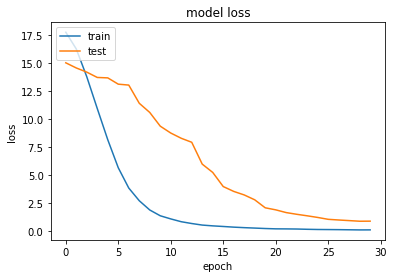

In [14]:
draw_loss_diagram_of_history(history)

### See Predictions
return `true_word` and `predicted_word` from `X_test` and `y_test`

In [15]:
characters = list(unique_chars.keys())    
predicted_word = []
true_word = []

for i, sample in enumerate(X_test):
    sample = np.reshape(X_test[i] , images[0][np.newaxis, :].shape)
    sample = model.predict(sample)
    sample = np.reshape(sample ,(DEFAULT_CAPTCHA_LENGTH, unique_chars_count))  
    predicted = ''.join([characters[np.argmax(i)] for i in sample])
    predicted_word.append(predicted)

for i in range(0, numTestingSamples):
    temp = ''.join([characters[i] for i in (np.argmax(y_test[:, i],axis=1))])
    true_word.append(temp)

1/1 [==============================] - 0s 44ms/step


#### Convert to csv
Convert true values and predicted values to dataframe and then make a csv file to show predictions

In [16]:
predicted_word = np.array(predicted_word)
true_word = np.array(true_word)
df = pd.DataFrame({'Predicted_value': predicted_word, 'True_value': list(true_word)}, columns=['Predicted_value', 'True_value'])
print(df)

    Predicted_value True_value
0             wxx4m      wxy4n
1             8n65n      8n65n
2             gwnm6      gwnm6
3             wxcn8      wxcn8
4             nf2n8      nf2n8
..              ...        ...
209           76353      76353
210           ppwyd      ppwyd
211           e6m6p      e6m6p
212           myf82      myf82
213           5nfff      5mfff

[214 rows x 2 columns]


In [17]:
df.to_csv('result.csv', index=False)